In [1]:
# NLI(Natural Language Interference:자연어 추론) 훈련 예제
#
# => input_ids : [CLS]senetence1(전제)[SEP]sentence2(가설)
# => attention_mask : 1111111111(전체,가설)0000000(그외)
# => token_type_ids : 0000000(전제)1111111(가설)00000000(그외)
# => laels : 참(수반:entailment), 거짓(모순:contradiction), 모름(중립:neutral)

import numpy as np
import pandas as pd
import torch
import os
import torch.nn.functional as F

from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, DistilBertConfig, AdamW, get_linear_schedule_with_warmup
from transformers import AutoTokenizer, BertForSequenceClassification
import sys
sys.path.append("../../")
from myutils import seed_everything, GPU_info, mlogging
from tqdm.notebook import tqdm

logger = mlogging(loggername="distilbertfttrain", logfilename="../../../log/distilbertftmultitrain")
device = GPU_info()
# Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
os.environ["TOKENIZERS_PARALLELISM"] = "false"


logfilepath:../../../log/distilbertftmultitrain_2022-10-23.log
True
device: cuda:0
cuda index: 0
gpu 개수: 1
graphic name: NVIDIA A30


In [ ]:
#############################################################################################
# 변수들 설정
# - model_path : from_pretrained() 로 호출하는 경우에는 모델파일이 있는 폴더 경로나 
#          huggingface에 등록된 모델명(예:'bert-base-multilingual-cased')
#          torch.load(model)로 로딩하는 경우에는 모델 파일 풀 경로
#
# - vocab_path : from_pretrained() 호출하는 경우에는 모델파일이 있는 폴더 경로나
#          huggingface에 등록된 모델명(예:'bert-base-multilingual-cased')   
#          BertTokenizer() 로 호출하는 경우에는 vocab.txt 파일 풀 경로,
#
# - OUTPATH : 출력 모델, vocab 저장할 폴더 경로
#############################################################################################

##################################################
# 변수 설정
##################################################
seed = 111
epochs = 10            # epochs
lr = 3e-5  # 학습률
p_itr = 200           # 손실률 보여줄 step 수
eps = 1e-8
max_seq_len = 72     # 글자 최대 토큰 길이 해당 토큰 길이 이상은 잘린다.
batch_size = 32      # 배치 사이즈(64면 GUP Memory 오류 나므로, 32 이하로 설정할것=>max_seq_length 를 줄이면, 64도 가능함)
##################################################

seed_everything(seed) # seed 설정

cache = True   # 캐쉬파일 생성할거면 True로 (True이면 loding할때 캐쉬파일있어도 이용안함)
train_file_fpath = '../../../data11/korpora/klue-nli/klue-nli-v1.1_train.json'
eval_file_fpath = '../../../data11/korpora/klue-nli/klue-nli-v1.1_dev.json'

# model 타입 : 0=distilbert, 1=bert, 2=Roberta
#=>Roberta 모델에는 distilbert처럼 token_type_id 입력 없음.
model_type = 1
model_path = 'jinmang2/kpfbert' #  #distilbert-base-multilingual-cased #bert-re-kowiki-bert-mecab 
vocab_path = 'jinmang2/kpfbert'
OUTPATH = '../../../data11/model/NLI/kpfbert-nli'

# tokeniaer 및 model 설정
# strip_accents=False : True로 하면, 가자 => ㄱ ㅏ ㅈ ㅏ 식으로 토큰화 되어 버림(*따라서 한국어에서는 반드시 False)
# do_lower_case=False : # 소문자 입력 사용 안함(한국어에서는 반드시 False)
tokenizer = AutoTokenizer.from_pretrained(vocab_path, strip_accents=False, do_lower_case=False) 
                        
# NLI 모델에서 레벨은 3개지(참,거짓,모름) 이므로, num_labels=3을 입력함

if model_type == 0:
    model = DistilBertForSequenceClassification.from_pretrained(model_path, num_labels=3)
elif model_type == 1:
    model = BertForSequenceClassification.from_pretrained(model_path, num_labels=3)

# 레벨을 멀티로 선택해야 하는 경우
#model = BertForSequenceClassification.from_pretrained(model_path, problem_type="multi_label_classification",num_labels=6)
                   
#기존 모델 파일을 로딩하는 경우    
#model = torch.load(model_path) 

model.to(device)

In [3]:
model.num_parameters()

114029571

In [4]:
# 학습 data loader 생성
sys.path.append('..')
from myutils import ClassificationDataset, KlueNLICorpus, data_collator
from torch.utils.data import DataLoader, RandomSampler

# corpus 파일 설정
corpus = KlueNLICorpus()

# 학습 dataset 생성
dataset = ClassificationDataset(file_fpath=train_file_fpath,max_seq_length=max_seq_len, tokenizer=tokenizer, corpus=corpus, overwrite_cache=cache)


# 학습 dataloader 생성
train_loader = DataLoader(dataset, 
                          batch_size=batch_size, 
                          #shuffle=True, # dataset을 섞음
                          sampler=RandomSampler(dataset, replacement=False), #dataset을 랜덤하게 샘플링함
                          collate_fn=data_collator, # dataset을 tensor로 변환(예시 {'input_ids':tensor[0,1,2,3,1,], 'token_type_id:tensor[0,0,0,0,0], 'attention_mask:tensor[1,1,1,1,1], 'labels':tensor[5]}
                          num_workers=4)

# 평가 dataset 생성

dataset = ClassificationDataset(file_fpath=eval_file_fpath, max_seq_length=max_seq_len, tokenizer=tokenizer, corpus=corpus, overwrite_cache=cache)

# 평가 dataloader 생성
eval_loader = DataLoader(dataset, 
                          batch_size=batch_size, 
                          #shuffle=True, # dataset을 섞음
                          sampler=RandomSampler(dataset, replacement=False), #dataset을 랜덤하게 샘플링함
                          collate_fn=data_collator, # dataset을 tensor로 변환(예시 {'input_ids':tensor[0,1,2,3,1,], 'token_type_id:tensor[0,0,0,0,0], 'attention_mask:tensor[1,1,1,1,1], 'labels':tensor[5]}
                          num_workers=4)

print('train_loader_len: {}, eval_loader_len: {}'.format(len(train_loader), len(eval_loader)))

Creating features from dataset file at ../../../data11/korpora/klue-nli/klue-nli-v1.1_train.json
loading data... LOOKING AT ../../../data11/korpora/klue-nli/klue-nli-v1.1_train.json
tokenize sentences, it could take a lot of time...
tokenize sentences [took %.3f s] 2.7156474590301514


  0%|          | 0/24998 [00:00<?, ?it/s]

*** Example ***
sentence A, B: 힛걸 진심 최고다 그 어떤 히어로보다 멋지다 + 힛걸 진심 최고로 멋지다.
tokens: [CLS] 힛 ##걸 진심 최고 ##다 그 어떤 히어로 ##보 ##다 멋지 ##다 [SEP] 힛 ##걸 진심 최고 ##로 멋지 ##다 . [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
label: entailment
features: ClassificationFeatures(input_ids=[2, 4338, 5055, 10742, 7047, 4577, 2675, 6928, 14715, 4557, 4577, 15960, 4577, 3, 4338, 5055, 10742, 7047, 4644, 15960, 4577, 518, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], attention_mask=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

  0%|          | 0/3000 [00:00<?, ?it/s]

*** Example ***
sentence A, B: 흡연자분들은 발코니가 있는 방이면 발코니에서 흡연이 가능합니다. + 어떤 방에서도 흡연은 금지됩니다.
tokens: [CLS] 흡연자 ##분 ##들 ##은 발코니 ##가 있 ##는 방 ##이면 발코니 ##에서 흡연 ##이 가능 ##합니다 . [SEP] 어떤 방 ##에서 ##도 흡연 ##은 금지 ##됩 ##니다 . [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
label: contradiction
features: ClassificationFeatures(input_ids=[2, 30424, 4694, 4811, 4769, 25438, 4556, 3748, 4753, 3266, 28747, 25438, 31822, 13367, 4534, 6865, 15801, 518, 3, 6928, 3266, 31822, 4538, 13367, 4769, 8241, 6778, 6808, 518, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], attention_mask=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [5]:
# tokenier 테스트
print(len(tokenizer))
print(tokenizer.encode("눈에 보이는 반전이었지만 영화의 흡인력은 사라지지 않았다", "정말 재미있다"))
print(tokenizer.convert_ids_to_tokens(131027))
print(tokenizer.convert_tokens_to_ids('정말'))

36440
[2, 2856, 4524, 6993, 4753, 12512, 4534, 4884, 6890, 6947, 4610, 4327, 4673, 4853, 4769, 9632, 4760, 3583, 6005, 4577, 3, 7186, 9421, 4577, 3]
None
7186


In [6]:
import time

logger.info(f"=== model: {model_path} ===")
logger.info(f"num_parameters: {model.num_parameters()}")

# 학습 시작

# optimizer 적용
optimizer = AdamW(model.parameters(), 
                 lr=lr, 
                 eps=eps) # 0으로 나누는 것을 방지하기 위한 epsilon 값(10^-6 ~ 10^-8 사이 이값 입력합)

# 총 훈련과정에서 반복할 스탭
total_steps = len(train_loader)*epochs

num_warmup_steps = total_steps * 0.1

# 스캐줄러 생성
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=num_warmup_steps, 
                                            num_training_steps=total_steps)

itr = 1
total_loss = 0
total_len = 0
total_correct = 0
list_training_loss = []
list_acc_loss = []
list_validation_acc_loss = []

model.zero_grad()# 그래디언트 초기화
for epoch in tqdm(range(epochs)):

    model.train() # 훈련모드로 변환
    for data in tqdm(train_loader):
    
        #optimizer.zero_grad()
        model.zero_grad()# 그래디언트 초기화
        
        # 입력 값 설정
        input_ids = data['input_ids'].to(device)
        if model_type == 1:
            token_type_ids = data['token_type_ids'].to(device) 
        attention_mask = data['attention_mask'].to(device)
        labels = data['labels'].to(device)
        #print('Labels:{}'.format(labels))
        
        # 모델 실행
        if model_type == 0:
            outputs = model(input_ids=input_ids, 
                            attention_mask=attention_mask,
                            labels=labels)
        else:
            outputs = model(input_ids=input_ids, 
                            token_type_ids=token_type_ids,
                            attention_mask=attention_mask,
                            labels=labels)
        
        # 출력값 loss,logits를 outputs에서 얻어옴
        loss = outputs.loss
        logits = outputs.logits
        #print('Loss:{}, logits:{}'.format(loss, logits))
        
        # optimizer 과 scheduler 업데이트 시킴
        loss.backward()   # backward 구함
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)   # 그래디언트 클리핑 (gradient vanishing이나 gradient exploding 방지하기 위한 기법)
        optimizer.step()  # 가중치 파라미터 업데이트(optimizer 이동)
        scheduler.step()  # 학습률 감소
        
        # 정확도와 손실률 계산하는 부분은 no_grade 시켜서, 계산량을 줄임.
        # => torch.no_grad()는 gradient을 계산하는 autograd engine를 비활성화 하여 
        # 필요한 메모리를 줄이고, 연산속도를 증가시키는 역활을 함
        with torch.no_grad():
            # 정확도와 총 손실률 계산
            pred = torch.argmax(F.softmax(logits), dim=1)
            correct = pred.eq(labels)
            total_correct += correct.sum().item()
            total_len += len(labels)    
            total_loss += loss.item()
            #print('pred:{}, correct:{}'.format(pred, correct))

            # 주기마다 test(validataion) 데이터로 평가하여 손실류 계산함.
            if itr % p_itr == 0:

                logger.info('[Epoch {}/{}] Iteration {} -> Train Loss: {:.4f}, Train Accuracy: {:.3f}'.format(epoch+1, epochs, itr, total_loss/p_itr, total_correct/total_len))

                list_training_loss.append(total_loss/p_itr)
                list_acc_loss.append(total_correct/total_len)

                total_loss = 0
                total_len = 0
                total_correct = 0

        itr+=1
        
        #if itr > 5:
        #    break
   
    ####################################################################
    # 1epochs 마다 실제 test(validattion)데이터로 평가 해봄
    # 평가 시작
    
    start = time.time()
    logger.info(f'---------------------------------------------------------')

    model.eval()
    
    total_test_correct = 0
    total_test_len = 0
    
    for data in tqdm(eval_loader):
        # 입력 값 설정
        input_ids = data['input_ids'].to(device)
        if model_type == 1:
            token_type_ids = data['token_type_ids'].to(device) 
        attention_mask = data['attention_mask'].to(device)
        labels = data['labels'].to(device)
 
        # 손실률 계산하는 부분은 no_grade 시켜서, 계산량을 줄임.
        # => torch.no_grad()는 gradient을 계산하는 autograd engine를 비활성화 하여 
        # 필요한 메모리를 줄이고, 연산속도를 증가시키는 역활을 함
        with torch.no_grad():
            # 모델 실행
              # 모델 실행
            if model_type == 0:
                outputs = model(input_ids=input_ids, 
                                attention_mask=attention_mask,
                                labels=labels)
            else:
                outputs = model(input_ids=input_ids, 
                                token_type_ids=token_type_ids,
                                attention_mask=attention_mask,
                                labels=labels)
    
            # 출력값 loss,logits를 outputs에서 얻어옴
            #loss = outputs.loss
            logits = outputs.logits
    
            # 총 손실류 구함
            pred = torch.argmax(F.softmax(logits), dim=1)
            correct = pred.eq(labels)
            total_test_correct += correct.sum().item()
            total_test_len += len(labels)
    
    list_validation_acc_loss.append(total_test_correct/total_test_len)
    logger.info("[Epoch {}/{}] Validatation Accuracy:{}".format(epoch+1, epochs, total_test_correct / total_test_len))
    logger.info(f'---------------------------------------------------------')
    logger.info(f'=== 처리시간: {time.time() - start:.3f} 초 ===')
    logger.info(f'-END-\n')
    ####################################################################
    

2022-10-23 09:46:30,215 - distilbertfttrain - INFO - === model: jinmang2/kpfbert ===
2022-10-23 09:46:30,217 - distilbertfttrain - INFO - num_parameters: 114029571
/MOCOMSYS/anaconda3/envs/bong/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

/tmp/ipykernel_68416/558753541.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = torch.argmax(F.softmax(logits), dim=1)
2022-10-23 09:47:05,219 - distilbertfttrain - INFO - [Epoch 1/10] Iteration 200 -> Train Loss: 1.0609, Train Accuracy: 0.403
2022-10-23 09:47:37,997 - distilbertfttrain - INFO - [Epoch 1/10] Iteration 400 -> Train Loss: 0.6024, Train Accuracy: 0.768
2022-10-23 09:48:10,524 - distilbertfttrain - INFO - [Epoch 1/10] Iteration 600 -> Train Loss: 0.4913, Train Accuracy: 0.815
2022-10-23 09:48:40,201 - distilbertfttrain - INFO - ---------------------------------------------------------


  0%|          | 0/94 [00:00<?, ?it/s]

/tmp/ipykernel_68416/558753541.py:140: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = torch.argmax(F.softmax(logits), dim=1)
2022-10-23 09:48:45,313 - distilbertfttrain - INFO - [Epoch 1/10] Validatation Accuracy:0.8236666666666667
2022-10-23 09:48:45,315 - distilbertfttrain - INFO - ---------------------------------------------------------
2022-10-23 09:48:45,316 - distilbertfttrain - INFO - === 처리시간: 5.116 초 ===
2022-10-23 09:48:45,317 - distilbertfttrain - INFO - -END-



  0%|          | 0/782 [00:00<?, ?it/s]

2022-10-23 09:48:48,676 - distilbertfttrain - INFO - [Epoch 2/10] Iteration 800 -> Train Loss: 0.4583, Train Accuracy: 0.828
2022-10-23 09:49:21,405 - distilbertfttrain - INFO - [Epoch 2/10] Iteration 1000 -> Train Loss: 0.3523, Train Accuracy: 0.878
2022-10-23 09:49:54,017 - distilbertfttrain - INFO - [Epoch 2/10] Iteration 1200 -> Train Loss: 0.3557, Train Accuracy: 0.876
2022-10-23 09:50:26,850 - distilbertfttrain - INFO - [Epoch 2/10] Iteration 1400 -> Train Loss: 0.3531, Train Accuracy: 0.872
2022-10-23 09:50:53,937 - distilbertfttrain - INFO - ---------------------------------------------------------


  0%|          | 0/94 [00:00<?, ?it/s]

2022-10-23 09:50:59,182 - distilbertfttrain - INFO - [Epoch 2/10] Validatation Accuracy:0.8533333333333334
2022-10-23 09:50:59,184 - distilbertfttrain - INFO - ---------------------------------------------------------
2022-10-23 09:50:59,186 - distilbertfttrain - INFO - === 처리시간: 5.249 초 ===
2022-10-23 09:50:59,188 - distilbertfttrain - INFO - -END-



  0%|          | 0/782 [00:00<?, ?it/s]

2022-10-23 09:51:05,526 - distilbertfttrain - INFO - [Epoch 3/10] Iteration 1600 -> Train Loss: 0.3077, Train Accuracy: 0.891
2022-10-23 09:51:38,238 - distilbertfttrain - INFO - [Epoch 3/10] Iteration 1800 -> Train Loss: 0.1887, Train Accuracy: 0.939
2022-10-23 09:52:11,030 - distilbertfttrain - INFO - [Epoch 3/10] Iteration 2000 -> Train Loss: 0.2070, Train Accuracy: 0.931
2022-10-23 09:52:43,713 - distilbertfttrain - INFO - [Epoch 3/10] Iteration 2200 -> Train Loss: 0.1976, Train Accuracy: 0.933
2022-10-23 09:53:07,585 - distilbertfttrain - INFO - ---------------------------------------------------------


  0%|          | 0/94 [00:00<?, ?it/s]

2022-10-23 09:53:12,777 - distilbertfttrain - INFO - [Epoch 3/10] Validatation Accuracy:0.8616666666666667
2022-10-23 09:53:12,778 - distilbertfttrain - INFO - ---------------------------------------------------------
2022-10-23 09:53:12,778 - distilbertfttrain - INFO - === 처리시간: 5.194 초 ===
2022-10-23 09:53:12,779 - distilbertfttrain - INFO - -END-



  0%|          | 0/782 [00:00<?, ?it/s]

2022-10-23 09:53:22,085 - distilbertfttrain - INFO - [Epoch 4/10] Iteration 2400 -> Train Loss: 0.1764, Train Accuracy: 0.943
2022-10-23 09:53:54,903 - distilbertfttrain - INFO - [Epoch 4/10] Iteration 2600 -> Train Loss: 0.1129, Train Accuracy: 0.966
2022-10-23 09:54:27,624 - distilbertfttrain - INFO - [Epoch 4/10] Iteration 2800 -> Train Loss: 0.1278, Train Accuracy: 0.960
2022-10-23 09:55:00,541 - distilbertfttrain - INFO - [Epoch 4/10] Iteration 3000 -> Train Loss: 0.1220, Train Accuracy: 0.962
2022-10-23 09:55:21,645 - distilbertfttrain - INFO - ---------------------------------------------------------


  0%|          | 0/94 [00:00<?, ?it/s]

2022-10-23 09:55:26,962 - distilbertfttrain - INFO - [Epoch 4/10] Validatation Accuracy:0.8613333333333333
2022-10-23 09:55:26,965 - distilbertfttrain - INFO - ---------------------------------------------------------
2022-10-23 09:55:26,967 - distilbertfttrain - INFO - === 처리시간: 5.321 초 ===
2022-10-23 09:55:26,968 - distilbertfttrain - INFO - -END-



  0%|          | 0/782 [00:00<?, ?it/s]

2022-10-23 09:55:39,146 - distilbertfttrain - INFO - [Epoch 5/10] Iteration 3200 -> Train Loss: 0.1085, Train Accuracy: 0.968
2022-10-23 09:56:11,775 - distilbertfttrain - INFO - [Epoch 5/10] Iteration 3400 -> Train Loss: 0.0907, Train Accuracy: 0.976
2022-10-23 09:56:44,581 - distilbertfttrain - INFO - [Epoch 5/10] Iteration 3600 -> Train Loss: 0.0828, Train Accuracy: 0.978
2022-10-23 09:57:17,288 - distilbertfttrain - INFO - [Epoch 5/10] Iteration 3800 -> Train Loss: 0.0766, Train Accuracy: 0.979
2022-10-23 09:57:35,296 - distilbertfttrain - INFO - ---------------------------------------------------------


  0%|          | 0/94 [00:00<?, ?it/s]

2022-10-23 09:57:40,529 - distilbertfttrain - INFO - [Epoch 5/10] Validatation Accuracy:0.8583333333333333
2022-10-23 09:57:40,531 - distilbertfttrain - INFO - ---------------------------------------------------------
2022-10-23 09:57:40,532 - distilbertfttrain - INFO - === 처리시간: 5.236 초 ===
2022-10-23 09:57:40,533 - distilbertfttrain - INFO - -END-



  0%|          | 0/782 [00:00<?, ?it/s]

2022-10-23 09:57:55,691 - distilbertfttrain - INFO - [Epoch 6/10] Iteration 4000 -> Train Loss: 0.0659, Train Accuracy: 0.980
2022-10-23 09:58:28,401 - distilbertfttrain - INFO - [Epoch 6/10] Iteration 4200 -> Train Loss: 0.0596, Train Accuracy: 0.986
2022-10-23 09:59:01,136 - distilbertfttrain - INFO - [Epoch 6/10] Iteration 4400 -> Train Loss: 0.0550, Train Accuracy: 0.987
2022-10-23 09:59:33,842 - distilbertfttrain - INFO - [Epoch 6/10] Iteration 4600 -> Train Loss: 0.0599, Train Accuracy: 0.984
2022-10-23 09:59:49,001 - distilbertfttrain - INFO - ---------------------------------------------------------


  0%|          | 0/94 [00:00<?, ?it/s]

2022-10-23 09:59:54,247 - distilbertfttrain - INFO - [Epoch 6/10] Validatation Accuracy:0.8716666666666667
2022-10-23 09:59:54,250 - distilbertfttrain - INFO - ---------------------------------------------------------
2022-10-23 09:59:54,251 - distilbertfttrain - INFO - === 처리시간: 5.250 초 ===
2022-10-23 09:59:54,252 - distilbertfttrain - INFO - -END-



  0%|          | 0/782 [00:00<?, ?it/s]

2022-10-23 10:00:12,198 - distilbertfttrain - INFO - [Epoch 7/10] Iteration 4800 -> Train Loss: 0.0519, Train Accuracy: 0.988
2022-10-23 10:00:44,859 - distilbertfttrain - INFO - [Epoch 7/10] Iteration 5000 -> Train Loss: 0.0265, Train Accuracy: 0.994
2022-10-23 10:01:17,333 - distilbertfttrain - INFO - [Epoch 7/10] Iteration 5200 -> Train Loss: 0.0423, Train Accuracy: 0.990
2022-10-23 10:01:49,854 - distilbertfttrain - INFO - [Epoch 7/10] Iteration 5400 -> Train Loss: 0.0355, Train Accuracy: 0.993
2022-10-23 10:02:02,025 - distilbertfttrain - INFO - ---------------------------------------------------------


  0%|          | 0/94 [00:00<?, ?it/s]

2022-10-23 10:02:07,189 - distilbertfttrain - INFO - [Epoch 7/10] Validatation Accuracy:0.8666666666666667
2022-10-23 10:02:07,192 - distilbertfttrain - INFO - ---------------------------------------------------------
2022-10-23 10:02:07,193 - distilbertfttrain - INFO - === 처리시간: 5.168 초 ===
2022-10-23 10:02:07,193 - distilbertfttrain - INFO - -END-



  0%|          | 0/782 [00:00<?, ?it/s]

2022-10-23 10:02:28,233 - distilbertfttrain - INFO - [Epoch 8/10] Iteration 5600 -> Train Loss: 0.0318, Train Accuracy: 0.992
2022-10-23 10:03:00,910 - distilbertfttrain - INFO - [Epoch 8/10] Iteration 5800 -> Train Loss: 0.0375, Train Accuracy: 0.993
2022-10-23 10:03:33,609 - distilbertfttrain - INFO - [Epoch 8/10] Iteration 6000 -> Train Loss: 0.0211, Train Accuracy: 0.994
2022-10-23 10:04:06,034 - distilbertfttrain - INFO - [Epoch 8/10] Iteration 6200 -> Train Loss: 0.0259, Train Accuracy: 0.994
2022-10-23 10:04:15,193 - distilbertfttrain - INFO - ---------------------------------------------------------


  0%|          | 0/94 [00:00<?, ?it/s]

2022-10-23 10:04:20,435 - distilbertfttrain - INFO - [Epoch 8/10] Validatation Accuracy:0.8706666666666667
2022-10-23 10:04:20,437 - distilbertfttrain - INFO - ---------------------------------------------------------
2022-10-23 10:04:20,439 - distilbertfttrain - INFO - === 처리시간: 5.246 초 ===
2022-10-23 10:04:20,440 - distilbertfttrain - INFO - -END-



  0%|          | 0/782 [00:00<?, ?it/s]

2022-10-23 10:04:44,407 - distilbertfttrain - INFO - [Epoch 9/10] Iteration 6400 -> Train Loss: 0.0192, Train Accuracy: 0.996
2022-10-23 10:05:16,978 - distilbertfttrain - INFO - [Epoch 9/10] Iteration 6600 -> Train Loss: 0.0170, Train Accuracy: 0.996
2022-10-23 10:05:49,976 - distilbertfttrain - INFO - [Epoch 9/10] Iteration 6800 -> Train Loss: 0.0148, Train Accuracy: 0.997
2022-10-23 10:06:22,791 - distilbertfttrain - INFO - [Epoch 9/10] Iteration 7000 -> Train Loss: 0.0140, Train Accuracy: 0.997
2022-10-23 10:06:29,096 - distilbertfttrain - INFO - ---------------------------------------------------------


  0%|          | 0/94 [00:00<?, ?it/s]

2022-10-23 10:06:34,367 - distilbertfttrain - INFO - [Epoch 9/10] Validatation Accuracy:0.874
2022-10-23 10:06:34,369 - distilbertfttrain - INFO - ---------------------------------------------------------
2022-10-23 10:06:34,370 - distilbertfttrain - INFO - === 처리시간: 5.274 초 ===
2022-10-23 10:06:34,371 - distilbertfttrain - INFO - -END-



  0%|          | 0/782 [00:00<?, ?it/s]

2022-10-23 10:07:01,151 - distilbertfttrain - INFO - [Epoch 10/10] Iteration 7200 -> Train Loss: 0.0125, Train Accuracy: 0.997
2022-10-23 10:07:33,812 - distilbertfttrain - INFO - [Epoch 10/10] Iteration 7400 -> Train Loss: 0.0161, Train Accuracy: 0.996
2022-10-23 10:08:06,518 - distilbertfttrain - INFO - [Epoch 10/10] Iteration 7600 -> Train Loss: 0.0127, Train Accuracy: 0.998
2022-10-23 10:08:39,218 - distilbertfttrain - INFO - [Epoch 10/10] Iteration 7800 -> Train Loss: 0.0131, Train Accuracy: 0.998
2022-10-23 10:08:42,573 - distilbertfttrain - INFO - ---------------------------------------------------------


  0%|          | 0/94 [00:00<?, ?it/s]

2022-10-23 10:08:47,770 - distilbertfttrain - INFO - [Epoch 10/10] Validatation Accuracy:0.8723333333333333
2022-10-23 10:08:47,773 - distilbertfttrain - INFO - ---------------------------------------------------------
2022-10-23 10:08:47,774 - distilbertfttrain - INFO - === 처리시간: 5.201 초 ===
2022-10-23 10:08:47,775 - distilbertfttrain - INFO - -END-



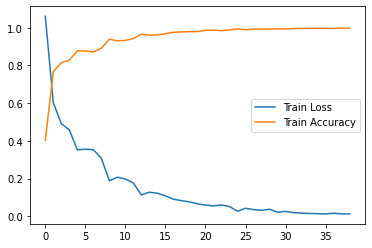

In [7]:
# 그래프로 loss 표기
#!pip install matplotlib
import matplotlib.pyplot as plt

plt.plot(list_training_loss, label='Train Loss')
plt.plot(list_acc_loss, label='Train Accuracy')
plt.legend()
plt.show()

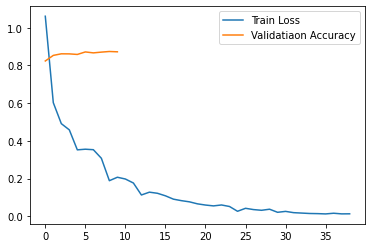

In [8]:
# train loss와 Validatiaon acc 출력
plt.plot(list_training_loss, label='Train Loss')
plt.plot(list_validation_acc_loss, label='Validatiaon Accuracy')
plt.legend()
plt.show()

In [9]:
### 전체모델 저장
#OUTPATH = '../model/distilbert/distilbert-model-0317-distillation-best-nli'

os.makedirs(OUTPATH, exist_ok=True)
#torch.save(model, OUTPATH + 'pytorch_model.bin') 
model.save_pretrained(OUTPATH)  # save_pretrained 로 저장하면 config.json, pytorch_model.bin 2개의 파일이 생성됨

# tokeinizer 파일 저장
VOCAB_PATH = OUTPATH
os.makedirs(VOCAB_PATH, exist_ok=True)
tokenizer.save_pretrained(VOCAB_PATH)

('../../../data11/model/NLI/kpfbert-nli/tokenizer_config.json',
 '../../../data11/model/NLI/kpfbert-nli/special_tokens_map.json',
 '../../../data11/model/NLI/kpfbert-nli/vocab.txt',
 '../../../data11/model/NLI/kpfbert-nli/added_tokens.json',
 '../../../data11/model/NLI/kpfbert-nli/tokenizer.json')